# Embeddings Model - Trained with full reviews

We will proceed to use embeddings as a representation of the reviews.  
Using doc2vec, we can project the reviews to a vector space where the distances between document vectors (and word vectors) reflect the distance in meaning.
This lets us capture the distance of a given review from the positive and negative reviews, considering the words in their context (instead of in isolation like in TF-IDF).

In [25]:
from spacy.lang.en import English
import spacy
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from collections import defaultdict
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import string
import pandas as pd
import numpy as np
from random import shuffle
import pickle
import re
from utils import Clustering_utils, Plotting_utils, Features_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

punctuations = string.punctuation
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
parser = English()

In [3]:
# Load datasets
X_train = pd.read_csv('data/X_train.csv', header=None, names=['text'])
X_train['text'] = X_train['text'].apply(lambda text: re.sub('\n', '', text))
X_test = pd.read_csv('data/X_test.csv', header=None, names=['text'])
X_test['text'] = X_test['text'].apply(lambda text: re.sub('\n', '', text))
Y_train = pd.read_csv('data/Y_train.csv', header=None, names=['label'])
Y_test = pd.read_csv('data/Y_test.csv', header=None, names=['label'])

# doc2vec

We will now build a model to vectorize the reviews

### Prepare dataset

In [2]:
# We divide the data according to its label to generate tags for the reviews
# Doc2vec requires a unique identifier for each doc, and we will use its label as part of the tag
train_pos_sentences = X_train[Y_train['label'] == 'positive'].to_dict()
train_neg_sentences = X_train[Y_train['label'] == 'negative'].to_dict()
train_neu_sentences = X_train[Y_train['label'] == 'neutral'].to_dict()
train = {'pos':train_pos_sentences['text'], 'neu':train_neu_sentences['text'], 'neg':train_neg_sentences['text']}

## Functions to lemmatize data

In [6]:
# We will use this class to tag each document before feeding it to doc2vec
class TaggedDocumentParagraph(object):
    def __init__(self, sets_):
        self.sets_ = sets_
        self.parser = English()
        self.paragraphs = []
        self.tags = []
    
    def tag(self):
        #Tag will take the dictionary of label[review]
        #Lemmatize each word, filter punctuation, stopwords and pronouns, and create a list of tokens for the review
        #TaggedDocument is called on each review (a list of tokens) and a tag is generates using its label and review number.
        for sentiment, reviews in self.sets_.items():
            for r, text in reviews.items():
                parsedText = self.parser(text.strip().lower())
                paragraphClean = []
                for token in parsedText:
                    if token.lemma_ != "-PRON-":
                        if (token.is_stop == False) & (token.lemma_ not in punctuations) & (token.lemma_ not in [' ']):
                            paragraphClean.append(token.lemma_)
                self.paragraphs.append(TaggedDocument(words=paragraphClean, tags=[sentiment + '%s' % r]))
    
    def paragraphs_shuffle(self):
        shuffle(self.paragraphs)
        return self.paragraphs

# Generate tagged docuements
reviewsTrain = TaggedDocumentParagraph(train)
reviewsTrain.tag()
# Save
with open('paragraphsTrain', 'wb') as fp:
    pickle.dump(reviewsTrain.paragraphs, fp)

with open('paragraphsTagsTrain', 'wb') as fp:
    pickle.dump(reviewsTrain.tags, fp)

In [2]:
# Load tagged documents
with open ('paragraphsTrain', 'rb') as fp:
    paragraphsTrain = pickle.load(fp)

## Train embedding

In [4]:
#We build the model class
model = Doc2Vec(min_count=1, window=10, size=300, sample=1e-4, negative=5, workers=4)
#Create vocabulary from the data
#model.build_vocab(reviewsTrain.paragraphs)
model.build_vocab(paragraphsTrain)
#Each model.epoch makes 5 passes through the data, so we are doing 50 epochs inside the loop
for epoch in range(10):
    # Is recommended to shuffle the documents between each training
    shuffle(paragraphsTrain)
    model.train(paragraphsTrain, total_examples=model.corpus_count, epochs=model.epochs)
    #model.train(reviewsTrain.paragraphs_shuffle(), total_examples=model.corpus_count, epochs=model.epochs)
#save model
model.save('paragraphsReviews.d2v')

/home/fer/anaconda3/envs/froneus/lib/python3.6/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [6]:
# Load model.
model = gensim.models.Word2Vec.load("models/doc2vec/paragraphs/paragraphsReviews.d2v")
model

In [12]:
# Sanity check of the vector space
# The average of the vectors of the words must be related to similar words in meaning

tok = ['breakfast','early']
simVec = []
for w in tok:
    if w in model.wv.vocab.keys():
        ivec = model.wv.get_vector(w)
        simVec.append([ivec])
meanVector = np.mean(simVec, axis=0).reshape((300,))
model.wv.most_similar(positive=[meanVector], topn=10)

[('breakfast', 0.8508018255233765),
 ('early', 0.8365453481674194),
 ('morning', 0.7069458961486816),
 ('sunday', 0.6876626014709473),
 ('lunch', 0.6648703217506409),
 ('day', 0.6532760858535767),
 ('saturday', 0.6381857395172119),
 ('weekend', 0.6327494978904724),
 ('late', 0.6284310817718506),
 ('open', 0.6258066892623901)]

# Reviews to vectors

We will now build a class that uses the model to vectorize the reviews, and train a classifier over the projected space.

In [56]:
class cleaner(TransformerMixin):
    #Removes trailing space, turns to lowercase and removes newlines
    def transform(self, X, **transform_params):
        res = [text.strip().lower() for text in X.text]
        return res

    def fit(self, X, y=None, **fit_params):
        return self

class tokenizer(TransformerMixin):
    # Lemmatizes the reviews
    def transform(X,parser=parser, **transform_params):
        reviews_tokens = []
        for text in X:
            parsedText = parser(text)
            token_list = []
            for token in parsedText:
                if token.lemma_ != "-PRON-":
                    if (token.is_stop == False) & (token.lemma_ not in punctuations):
                        token_list.append(token.lemma_)
            reviews_tokens.append(token_list)
        return reviews_tokens
    
    def fit(self, X, y=None, **fit_params):
        return self

class vectorizer(TransformerMixin):
    # Projects the reviews to the vector space using the doc2vec model
    def transform(self, X, model=model, **transform_params):
        vecs = []
        for review in X:
            revVec = []
            for w in review:
                # If the word is in the vocabulary, return the learned projection
                if w in model.wv.vocab.keys():
                    wvec = model.wv.get_vector(w)
                    revVec.append([wvec])
                # If the word is new, infer its vector
                else:
                    wvec = model.infer_vector([w])
                    revVec.append([wvec])
            meanVector = np.mean(revVec, axis=0).reshape((300,))
            vecs.append(meanVector)
        return vecs

    def fit(self, X, y=None, **fit_params):
        return self

# Build pipe
steps = [("cleaner", cleaner()),('tokenizer', tokenizer),('vectorizer', vectorizer())]
pipe = Pipeline(steps)
# Project the reviews
vectorizedReviews_train=pipe.transform(X_train)
vectorizedReviews_test=pipe.transform(X_test)
# Save the projected reviews
vectorizedReviewsDF = pd.DataFrame.from_records(vectorizedReviews_train)
vectorizedReviewsDF.to_csv('data/vectorized/train_vectorizedReviews_paragraphs.csv',index=False)
vectorizedReviewsDF = pd.DataFrame.from_records(vectorizedReviews_test)
vectorizedReviewsDF.to_csv('data/vectorized/test_vectorizedReviews_paragraphs.csv',index=False)

# Gridsearch

We proceed to do a gridsearch with crossvalidation over **Randomforest**  
We chose booosting algorithms because they scale nicely with the number of variables, are nonlinear and robust to noise, which we saw is what we need. Ther are also generally a great benchmark.

#### Since there is a tight time constraint, we will not do an exhaustive parameter space search. We will focus on showing the process of optimizing the models. It is very probable that we will arrive at overfited models or suboptimal parameters.

#### We will use fewer CV folds than reocmended, to accelerate training time. We will also try only a couple of parameters per algorithm. This will highly increase the probability of overfit.

#### Given that the classess are unbalanced, there will be a bias towards positive clasification. It is reccomended either for the observations to be weighted according to their unbalance or to use oversampling for the negative and neutral classes.

#### Randomforest

RandomForest fits several trees, each to a random sample of variables and rows from the original data. This combination of boosting and random sampling makes it very robust to noise and capable of handling a lot of variables.  

Due to the time constraint, we will only optimize for number of trees and their max depth.

In [ ]:
# read vectorized reviews
X_trainVec = pd.read_csv('data/vectorized/train_vectorizedReviews_paragraphs.csv')
#Generate model pipeline
rf_pipeline = Pipeline([('model', RandomForestClassifier())])

#Gridsearch params
RandomForest_param_grid = { 
    'model__n_estimators': [200,1200],
    'model__max_depth' : [32,50],
    'model__max_features': ['auto'],
    'model__criterion' :['entropy'],
    'model__random_state' : [91]
}

#search
grid = GridSearchCV(rf_pipeline, param_grid=RandomForest_param_grid, cv=3,n_jobs=4,verbose=4)
rf_grid_result = grid.fit(X_trainVec, Y_train)

In [11]:
# Gridsearch results to dataframe
cvresults = pd.DataFrame.from_dict(rf_grid_result.cv_results_)
cvresults = pd.concat([cvresults.drop('params',axis=1),cvresults.params.apply(pd.Series)],axis=1)
cvresults.to_csv('doc2vecParagraph_cvresultsRF_1.csv', index=False)
cvresults

# Testing

We proceed to evaluate the models performance over the test split (30%).  
We will use a common performance metric, **confusion matrix**, which measures the number of correctly and incorrectly classified examples. Helps to check the level of overfitting. It has the drawback that it must use a fixed threshold, thus, may be biased because the best threshold may not be the one used.

In [4]:
X_trainVec = pd.read_csv('data/vectorized/train_vectorizedReviews_paragraphs.csv')
X_testVec = pd.read_csv('data/vectorized/test_vectorizedReviews_paragraphs.csv')

# Build model with best params
rf = RandomForestClassifier(n_estimators= 200,max_depth = 50,max_features= 'auto',criterion= 'entropy',random_state= 91,verbose=10,n_jobs=4)

#train
rf.fit(X_trainVec, Y_train)
#test
predicted_Y = rf.predict(X_testVec)
predicted_Y_train = rf.predict(X_trainVec)

/home/fer/anaconda3/envs/froneus/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   31.9s


building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200


[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   48.2s


building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200


[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min


building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.6min


building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.4min


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.9min


building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200


[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.7min


building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200


[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.3min


building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200


[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.3min


building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200


[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  6.1min


building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building tree 106 of 200
building tree 107 of 200
building tree 108 of 200


[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  7.2min


building tree 109 of 200
building tree 110 of 200
building tree 111 of 200
building tree 112 of 200
building tree 113 of 200
building tree 114 of 200
building tree 115 of 200
building tree 116 of 200
building tree 117 of 200
building tree 118 of 200
building tree 119 of 200
building tree 120 of 200
building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200


[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  8.1min


building tree 125 of 200
building tree 126 of 200
building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200
building tree 131 of 200
building tree 132 of 200
building tree 133 of 200
building tree 134 of 200
building tree 135 of 200
building tree 136 of 200
building tree 137 of 200
building tree 138 of 200
building tree 139 of 200
building tree 140 of 200
building tree 141 of 200


[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  9.4min


building tree 142 of 200
building tree 143 of 200
building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200
building tree 154 of 200
building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.5min


building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200


[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 11.8min


building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 12.9min


building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed: 13.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    5

### Visualization of projected space

We graph 1000 reviews projected on the 30 vectors that offer the best separability.  
We can observe that there is a lot of overlap in the classes distribution, which indicates that there is not a small group of variables that lets the model separate the classes.


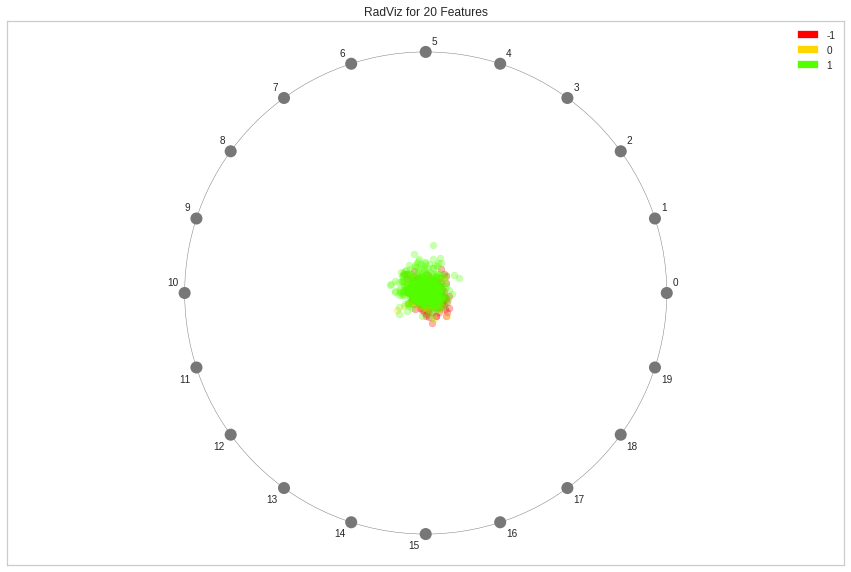

In [26]:
sample = np.random.choice(X_trainVec.shape[0],1000)
sample_X = X_trainVec.iloc[sample]
sample_Y = Y_train.iloc[sample].reset_index(drop=True)
best_vars = rf.feature_importances_.argsort()[-20:][::-1]
sample_X = sample_X.iloc[:,list(best_vars)].T.reset_index(drop=True).T
sample_X = sample_X.reset_index(drop=True)
#Radviz for best features
sample_Y_ = sample_Y['label'].apply(lambda x: 1 if x=='positive' else 0 if x=='neutral' else -1)
Plotting_utils.plot_RadViz(sample_X,sample_Y_)

Confusion matrix - Training 
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


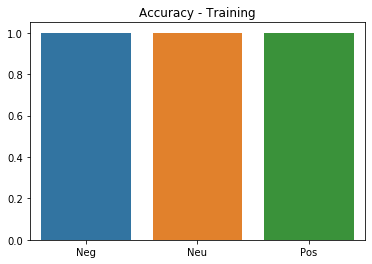

In [22]:
%matplotlib inline
cm = confusion_matrix(Y_train,predicted_Y_train)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Training \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Training")

Confusion matrix - Testing 
 [[0.77 0.   0.23]
 [0.23 0.01 0.76]
 [0.03 0.   0.97]]


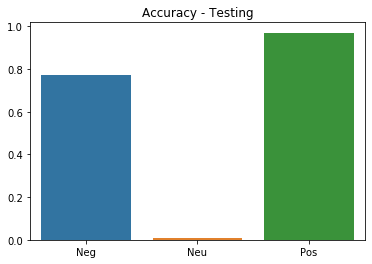

In [23]:
cm = confusion_matrix(Y_test,predicted_Y)
cm = np.array([round(s/sum(cm[i]),2) for i,score in enumerate(cm) for s in score]).reshape(3,3)
print('Confusion matrix - Testing \n', cm)
_ = sns.barplot(x=['Neg','Neu','Pos'],y=[cm[i][i] for i,x in enumerate(cm)]).set_title("Accuracy - Testing")

In [10]:
import pickle
# save model to file
pickle.dump(rf, open("models/doc2vec/paragraphs/RF.p", "wb"))